<a href="https://colab.research.google.com/github/AuFeld/Project2/blob/master/notebooks/Project_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
DATA_PATH = 'Project_2_Data.xlsx'

In [6]:
pip install category_encoders

In [0]:
# import libraries
import pandas as pd
import pandas_profiling
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

In [0]:
df = pd.read_excel(DATA_PATH)

In [9]:
df.head()

,Club,Season,Expenditure,Income,Net,Points,Expenditure_per_Point,Manager,Owner
0,MCI,2019,-191.52,78.66,-112.86,0,0.0,Guardiola,City_Football
1,MAN,2019,-181.26,79.23,-102.03,0,0.0,Solsjkaer,Glazer
2,ARS,2019,-173.74,61.05,-112.69,0,0.0,Emery,Kroenke
3,AVL,2019,-169.40,0.00,-169.40,0,0.0,D_Smith,Sawiris
4,EVE,2019,-136.69,91.77,-44.92,0,0.0,Silva,Moshiri


In [0]:
# choose your target. which column in will you predict? 
# target: 2019 points

In [0]:
# regression or classification?
# regression

In [0]:
# evaluation metrics: MAE

In [0]:
columns = ['Club', 'Season', 'Expenditure', 'Income', 'Net', 'Points',
           'Expenditure_per_Point', 'Manager', 'Owner']

In [0]:
# split data by season

train = df[df['Season'] < 2018]
val = df[df['Season'] == 2018]
test = df[df['Season'] == 2019]

In [15]:
train.shape, val.shape, test.shape

((460, 9), (20, 9), (20, 9))

In [16]:
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
Club,460,47,TOT,23
Owner,460,66,ITV_plc,23
Manager,460,136,Wenger,23


In [0]:
# assign variables
target = 'Points'
features = df.columns.drop([target])

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

In [18]:
# null values?
df.isna().sum()

Club                     0
Season                   0
Expenditure              0
Income                   0
Net                      0
Points                   0
Expenditure_per_Point    0
Manager                  0
Owner                    0
dtype: int64

In [19]:
# get your baseline
baseline = train['Points'].mean()
print(baseline)

52.03913043478261


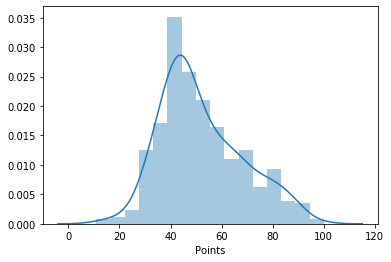

In [20]:
# skew? 
%matplotlib inline

sns.distplot(y_train);

In [21]:
# fit linear regression model

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

lr = make_pipeline(
    ce.TargetEncoder(),  
    LinearRegression()
)

lr.fit(X_train, y_train)
print('Linear Regression R^2', lr.score(X_val, y_val))

Linear Regression R^2 0.8146430497286438


In [22]:
# explaining linear regression

coefficients = lr.named_steps['linearregression'].coef_
pd.Series(coefficients, features)

Club                      -0.020976
Season                     0.123841
Expenditure             -358.720413
Income                  -358.454158
Net                      358.469484
Expenditure_per_Point     17.077125
Manager                    0.372564
Owner                      0.543465
dtype: float64

In [23]:
# fit gradient boosting model

from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.8230350260735059


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [0]:
# Linear models have coefficients, but tree ensembles do not.
# Instaed, to see the relationship between individual feature(s) and the target, 
# we can use partial dependence plots.

In [0]:
# Partial Dependence Plots

# increase the dots per inch (double it), so the text isn't so fuzzy
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72


In [26]:
#pip install pdp
pip install pdpbox

     |████████████████████████████████| 57.7MB 70kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690723 sha256=8f697297d8cb493e79da65d31d2e2b36721a6ead2a20df51b7b2f676a4702274
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Expenditure'

isolated = pdp_isolate(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


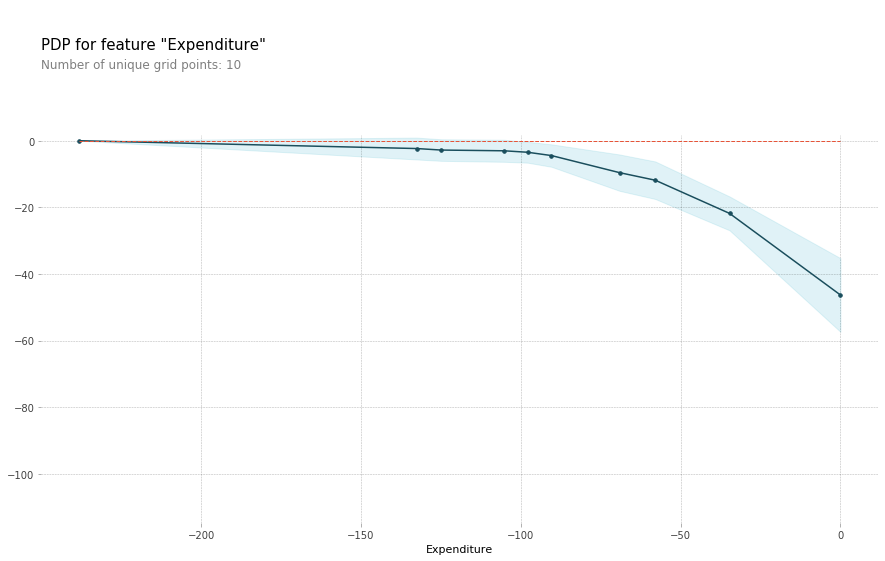

In [28]:
pdp_plot(isolated, feature_name=feature);

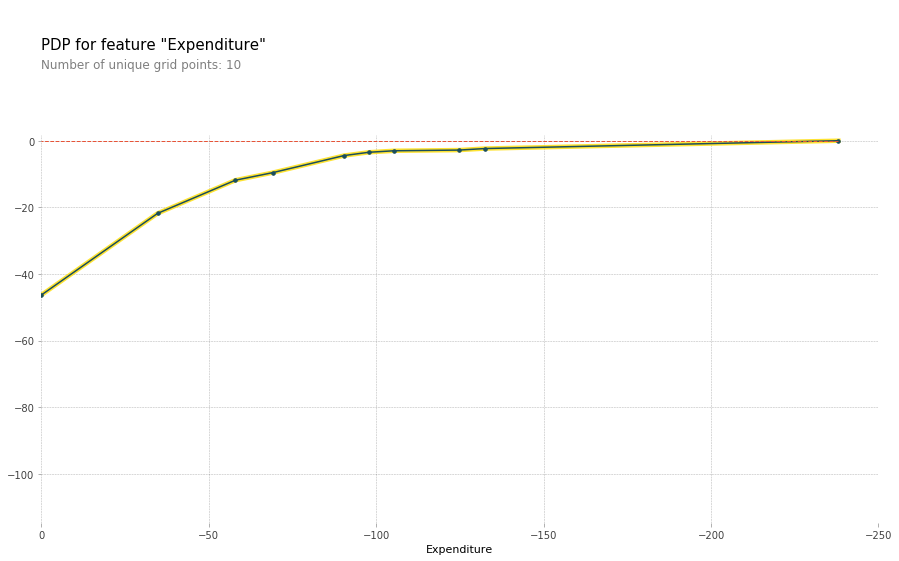

In [29]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, 
         frac_to_plot=0.01)

plt.xlim(0,-250);

In [0]:
# Partial Dependence Plots with 2 Features

from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [0]:
features = ['Income', 'Expenditure']

interaction = pdp_interact(
    model=gb, 
    dataset=X_val,
    model_features=X_val.columns, 
    features=features
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


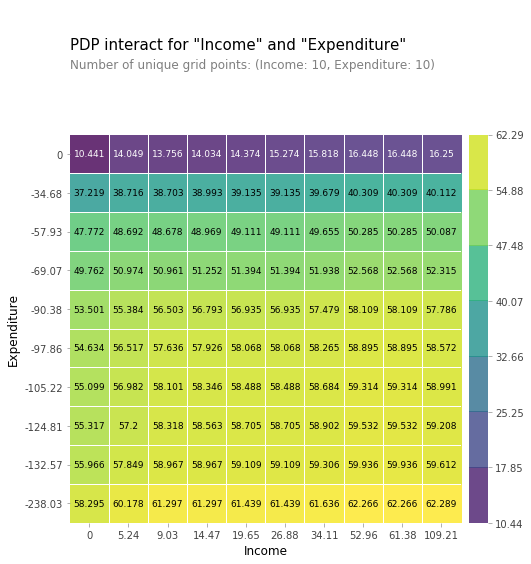

In [32]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

In [33]:
# PDP with Categorical Encoders

X = df[features]
y = df[target]

# Use Ordinal Encoder, outside of a pipeline
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_encoded, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

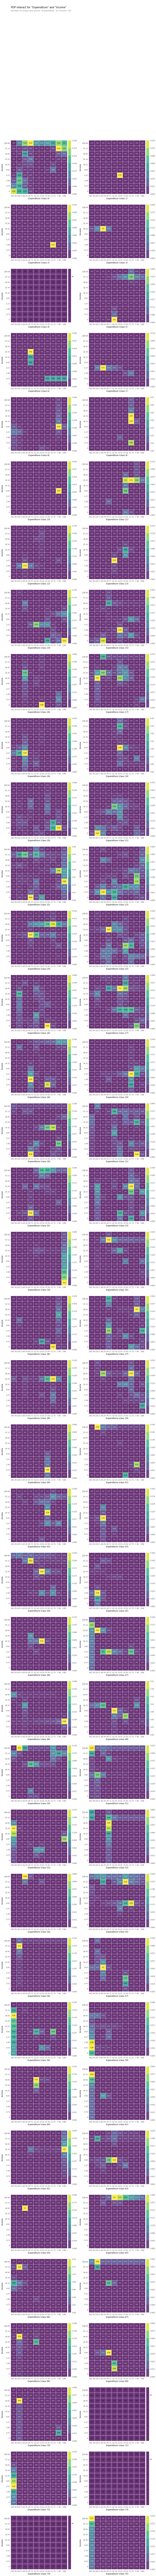

In [34]:
features = ['Expenditure', 'Income']

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [0]:
# AUC and ROC
# feature engineering
# focus on SHAP visualizations - most fresh
# 

In [0]:
# Shapley Values

In [0]:
features = ['Expenditure', 'Expenditure_per_Point', 'Income', 'Net']
target = 'Points'
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [38]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.4s finished


In [39]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'max_depth': 20, 'max_features': 0.9507143064099162, 'n_estimators': 156}
Cross-validation MAE 8.679222408026755


In [0]:
# Get an individual observation to explain.
# For example, the 0th row from the test set.

row = X_test.iloc[[0]]  # Dataframe with a single row (double brackets keeps it a dataframe)

In [41]:
# What was the actual value for this club?
y_test.iloc[[0]]

0    0
Name: Points, dtype: int64

In [42]:
pip install shap

     |████████████████████████████████| 266kB 4.6MB/s 
  Created wheel for shap: filename=shap-0.33.0-cp36-cp36m-linux_x86_64.whl size=382259 sha256=c9ed6b0c69157065e17587f18aef5debc9987f5376b8c398ce525d8a05529b34
  Stored in directory: /root/.cache/pip/wheels/39/0f/88/a8124d43431284e10f263ffe449e119344c6145c3a165d186c
Successfully built shap


In [43]:
# Why did the model predict this?
# Look at a Shapley Values Force Plot

import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [44]:
# Base value is approximately equal to the mean baseline
explainer.expected_value, y_train.mean()

(52.033779264214076, 52.03913043478261)

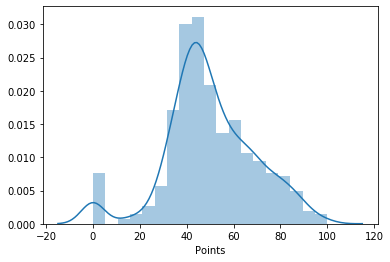

In [45]:
y = df['Points']
sns.distplot(y);

In [0]:
# log transform from _231 notes

import numpy as np
y_log = np.log1p(y)

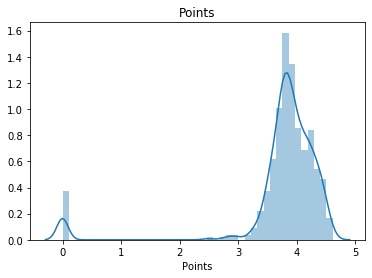

In [47]:

sns.distplot(y_log)
plt.title('Points');

'Ridge Regression, with alpha=0.001'

Test Mean Absolute Error: $101


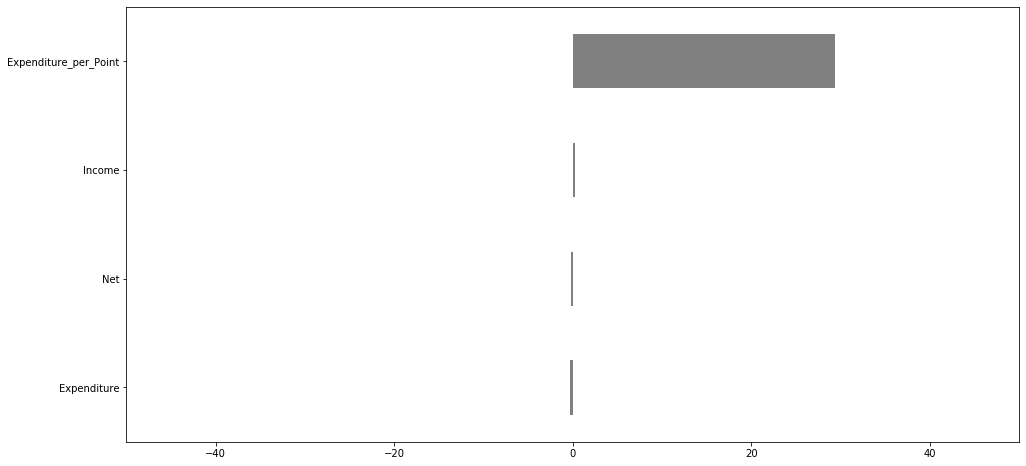

'Ridge Regression, with alpha=0.01'

Test Mean Absolute Error: $98


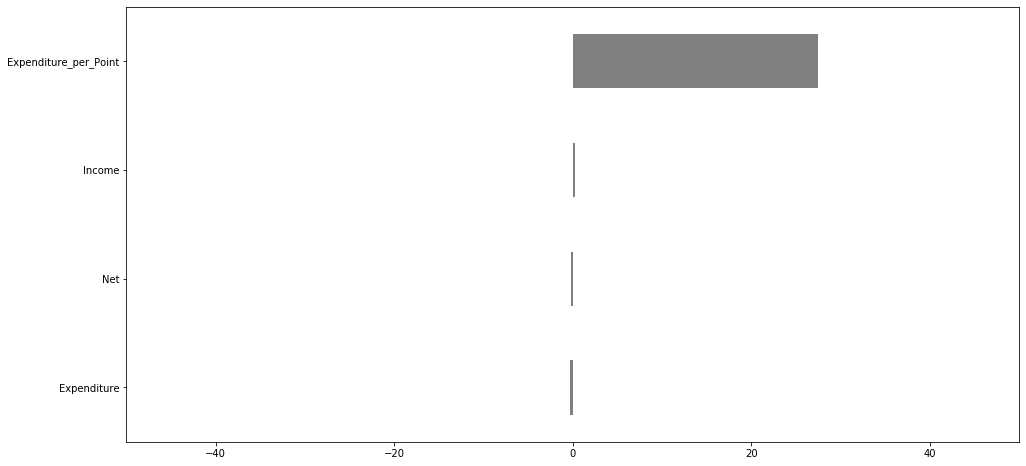

'Ridge Regression, with alpha=0.1'

Test Mean Absolute Error: $82


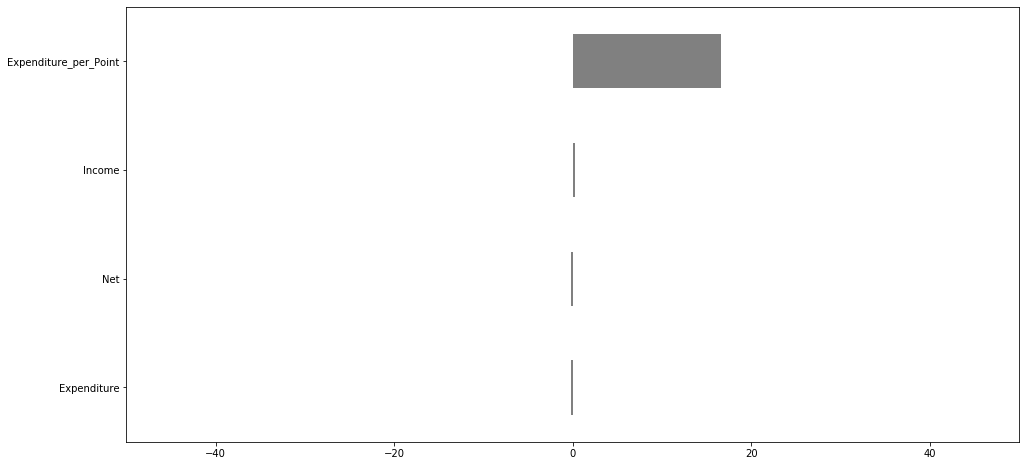

'Ridge Regression, with alpha=1.0'

Test Mean Absolute Error: $59


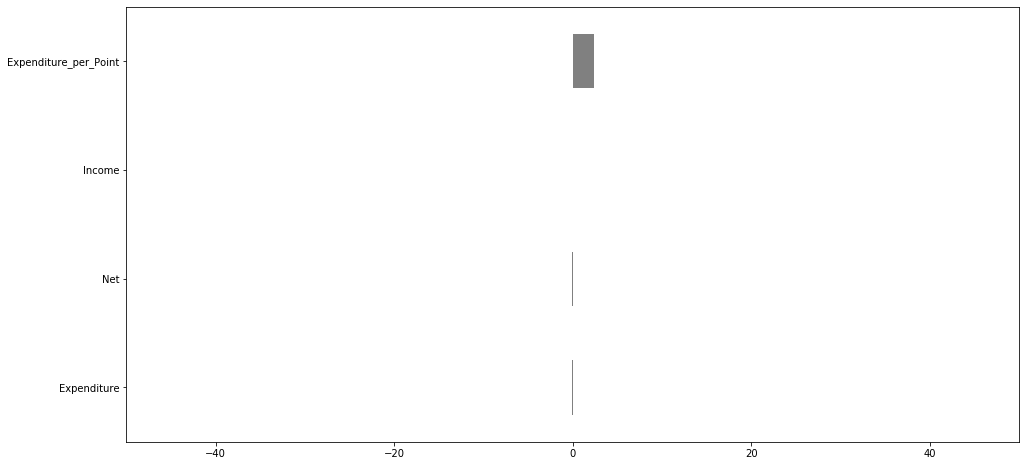

'Ridge Regression, with alpha=1'

Test Mean Absolute Error: $59


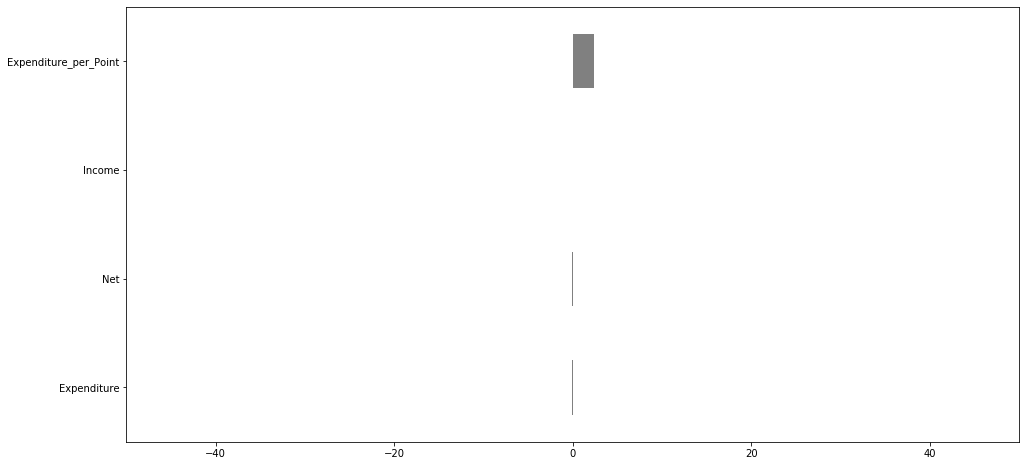

'Ridge Regression, with alpha=100.0'

Test Mean Absolute Error: $52


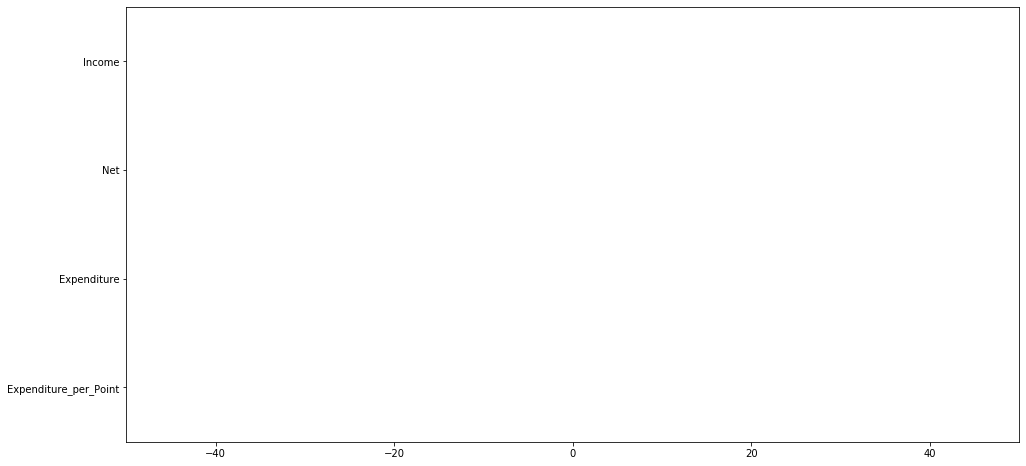

'Ridge Regression, with alpha=1000.0'

Test Mean Absolute Error: $52


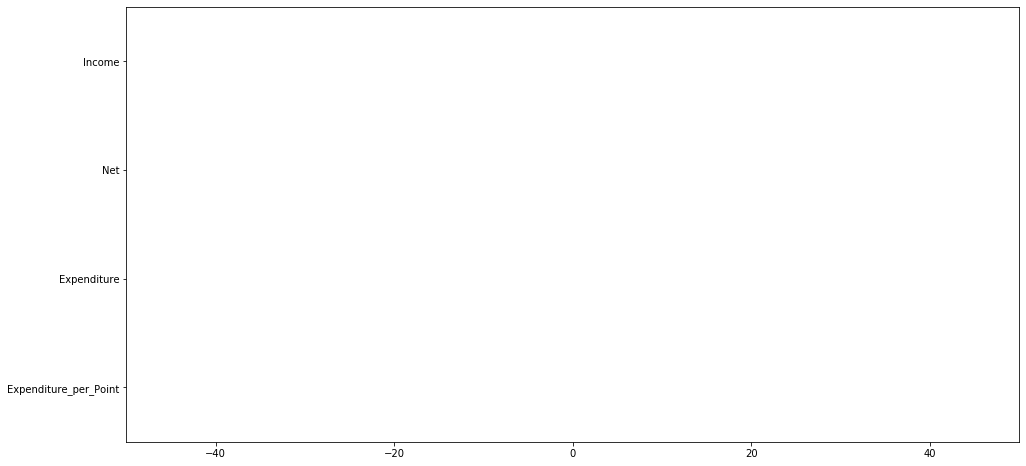

In [48]:
for alpha in [0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0]:
    
    # Fit Ridge Regression model
    display(f'Ridge Regression, with alpha={alpha}')
    model = Ridge(alpha=alpha, normalize=True, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Get Test MAE
    mae = mean_absolute_error(y_test, y_pred)
    # display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    print(f'Test Mean Absolute Error: ${mae:,.0f}')
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-50,50)
    plt.show()